In [7]:
# 1. Import thư viện
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

from sklearn.utils.class_weight import compute_sample_weight

In [8]:
# 2. Đọc file (đã scale = RobustScaling)
data = pd.read_csv("preprocessed_data.csv")
data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,weather_group,humidity_change,hour_sin,hour_cos,pressure_trend_6h,month_sin,month_cos,press_std_12h,hum_max_6h,temp_diff_3h
0,24.7,80,21.0,1013.3,96,10.4,Cloudy,4.0,-0.965926,-2.588190e-01,-2.2,0.5,0.866025,1.368808,80.0,-0.5
1,24.2,82,21.0,1013.6,87,6.8,Cloudy,2.0,-1.000000,-1.836970e-16,-1.3,0.5,0.866025,1.395990,82.0,-1.1
2,23.5,87,21.2,1014.1,40,5.3,Cloudy,5.0,-0.965926,2.588190e-01,0.1,0.5,0.866025,1.393383,87.0,-1.6
3,23.4,87,21.0,1015.3,83,5.6,Drizzle,0.0,-0.866025,5.000000e-01,2.1,0.5,0.866025,1.297083,87.0,-1.3
4,23.0,90,21.2,1015.4,86,5.9,Drizzle,3.0,-0.707107,7.071068e-01,2.7,0.5,0.866025,1.161862,90.0,-1.2


In [9]:
# 3. Tạo thêm features 
data['temp_hum_interaction'] = data['temperature_2m'] * data['relative_humidity_2m']
data['pressure_change_rate'] = data['pressure_trend_6h'] / 6
data['humidity_pressure_ratio'] = data['relative_humidity_2m'] / (data['surface_pressure'] / 1000)


In [10]:
# 4. Giữ lại features quan trọng
important_features = [
    'relative_humidity_2m',
    'dew_point_2m',
    'surface_pressure',
    'humidity_change',
    'pressure_trend_6h',
    'press_std_12h',
    'hum_max_6h',
    'temp_diff_3h',
    'temp_hum_interaction',
    'pressure_change_rate',
    'humidity_pressure_ratio'
]

In [11]:
# 5. Chọn target colum (encode), tính tổng số dữ liệu
X = data[important_features]
le = LabelEncoder()
y = le.fit_transform(data["weather_group"])

N = X.shape[0]

# kiem tra lai
labels = np.unique(y)

In [12]:
# 6. Chia tập train - validation - test theo tỷ lệ 7 - 2 - 1
train_end = int(0.7*N)
val_end = int(0.9*N)

X_train, y_train = X.iloc[:train_end], y[:train_end]
X_val, y_val = X.iloc[train_end : val_end], y[train_end : val_end]
X_test, y_test = X.iloc[val_end:], y[val_end:]

robust_scaler = RobustScaler()

X_train_scaled = robust_scaler.fit_transform(X_train)
X_val_scaled   = robust_scaler.transform(X_val)
X_test_scaled  = robust_scaler.transform(X_test)



In [13]:
# 7. Chống lệch nhãn trên y train
sample_weight = compute_sample_weight("balanced", y_train)

In [14]:
# pd.Series(y_train).value_counts(normalize=True) # ty le tung weather_group

# * 8. Model AdaBoost
# Định nghĩa lại Base Learner 
base_learner = DecisionTreeClassifier(
    max_depth= 5, 
    min_samples_leaf=30,
    min_samples_split=60,
    max_features="sqrt", # Giúp giảm overfitting
    random_state=42
)

# Tạo lưới tham số 
param_grid = {
    'n_estimators': [200,300,400],
    'learning_rate': [0.05,0.07,0.1],
}

# TimeSeriesSplit: Cơ chế chia dữ liệu theo trình tự thời gian 
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    AdaBoostClassifier(estimator=base_learner, algorithm="SAMME", random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weight)

print(f"Tham số tốt nhất: {grid_search.best_params_}")
model = grid_search.best_estimator_


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\TRAN THI TUYET TRINH\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Tham số tốt nhất: {'learning_rate': 0.07, 'n_estimators': 200}


In [15]:
# 9. Đánh giá
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

In [16]:
def evaluate_all(y_true, y_pred, name="", target_names=None):
    print(f"\n===== {name} SET =====")
    print(f"Accuracy            : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall (weighted)   : {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    print("\n--- Classification Report (per class) ---")
    print(classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        digits=4
    ))


In [17]:
class_names = le.classes_  # ['Cloud', 'Drizzle', 'Rain']

evaluate_all(y_train, y_train_pred, "TRAIN", class_names)
evaluate_all(y_val,   y_val_pred,   "VALIDATION", class_names)
evaluate_all(y_test,  y_test_pred,  "TEST", class_names)


===== TRAIN SET =====
Accuracy            : 0.6770
Precision (weighted): 0.7734
Recall (weighted)   : 0.6770
F1-score (weighted) : 0.7083

--- Classification Report (per class) ---
              precision    recall  f1-score   support

      Cloudy     0.8986    0.7016    0.7879      8572
     Drizzle     0.5270    0.5823    0.5533      3213
        Rain     0.2116    0.8640    0.3399       500

    accuracy                         0.6770     12285
   macro avg     0.5457    0.7160    0.5604     12285
weighted avg     0.7734    0.6770    0.7083     12285


===== VALIDATION SET =====
Accuracy            : 0.6564
Precision (weighted): 0.6941
Recall (weighted)   : 0.6564
F1-score (weighted) : 0.6547

--- Classification Report (per class) ---
              precision    recall  f1-score   support

      Cloudy     0.7990    0.7925    0.7957      2443
     Drizzle     0.5210    0.2316    0.3207       803
        Rain     0.2493    0.6894    0.3662       264

    accuracy                    

<Figure size 600x600 with 0 Axes>

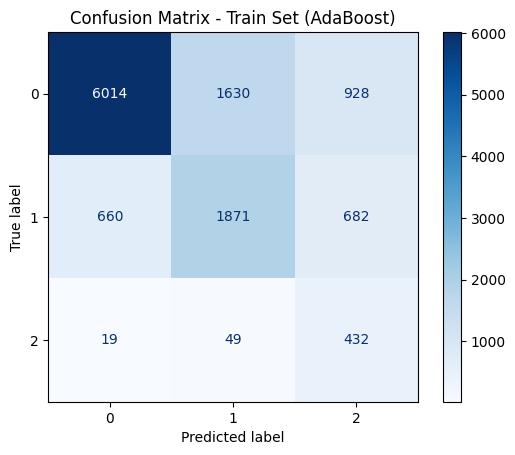

In [18]:
# 10. Vẽ ma trận nhầm lẫn trên tập train
cm_train = confusion_matrix(y_train, y_train_pred, labels=labels)

disp_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=labels
)

plt.figure(figsize=(6, 6))
disp_train.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - Train Set (AdaBoost)")
plt.show()


<Figure size 600x600 with 0 Axes>

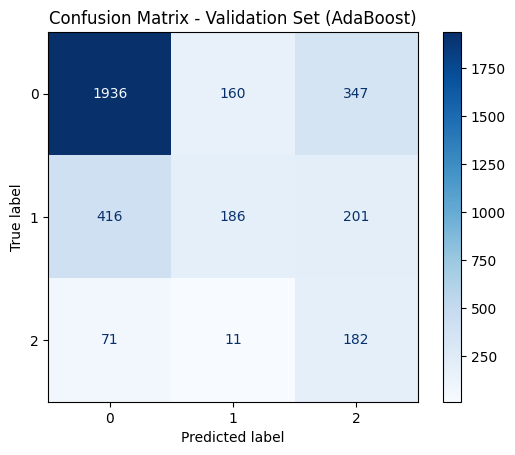

In [19]:
# Vẽ ma trận nhầm lẫn trên tập val
cm_val = confusion_matrix(y_val, y_val_pred, labels=labels)

disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=labels
)

plt.figure(figsize=(6, 6))
disp_val.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - Validation Set (AdaBoost)")
plt.show()


<Figure size 600x600 with 0 Axes>

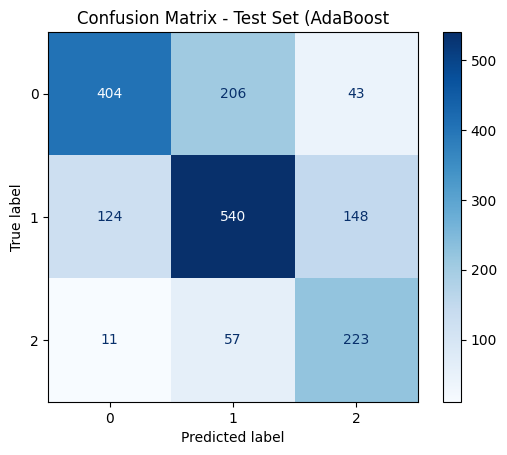

In [20]:
#  Vẽ ma trận nhầm lẫn trên tập test
cm = confusion_matrix(y_test, y_test_pred, labels= labels)

display = ConfusionMatrixDisplay(
    confusion_matrix= cm,
    display_labels= labels
)

plt.figure(figsize= (6,6))
display.plot(cmap= plt.cm.Blues, values_format= "d")
plt.title("Confusion Matrix - Test Set (AdaBoost")
plt.show()

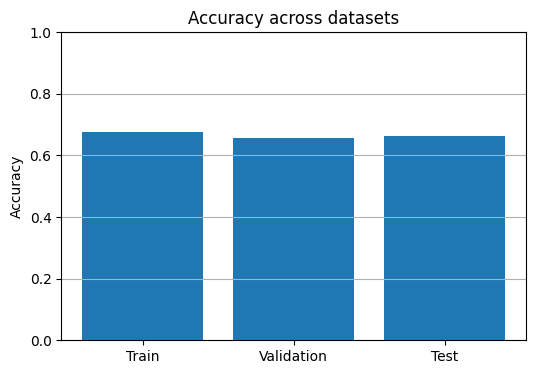

In [21]:
sets = ["Train", "Validation", "Test"]
accuracies = [
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_val, y_val_pred),
    accuracy_score(y_test, y_test_pred)
]

plt.figure(figsize=(6,4))
plt.bar(sets, accuracies)
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("Accuracy across datasets")
plt.grid(axis='y')
plt.show()


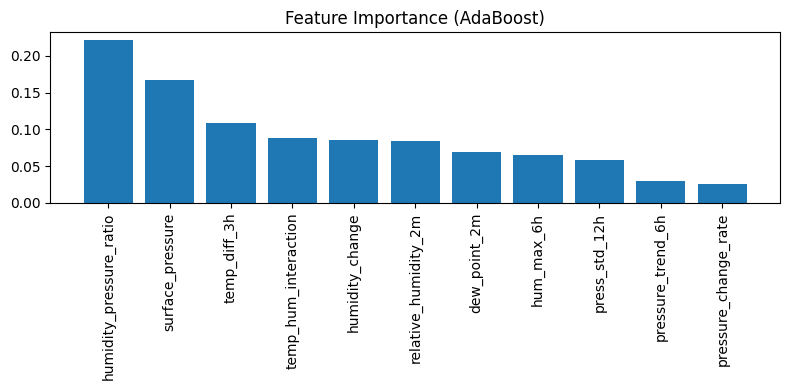

In [22]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)),
           X_train.columns[indices],
           rotation=90)
plt.title("Feature Importance (AdaBoost)")
plt.tight_layout()
plt.show()


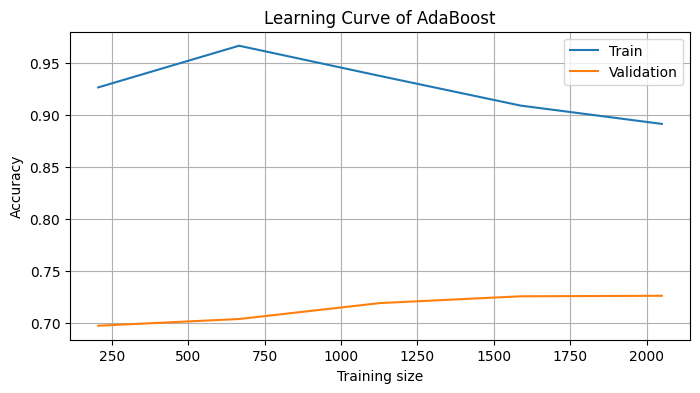

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_scaled, y_train,
    cv=TimeSeriesSplit(5),
    scoring='accuracy',
    n_jobs=-1
)

plt.figure(figsize=(8,4))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.title("Learning Curve of AdaBoost")
plt.legend()
plt.grid(True)
plt.show()
